In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "06_preprocessing/07b_gpumax.ipynb"
_nb_title = "GPU utilization"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=GPU utilization&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F06_preprocessing%2F07b_gpumax.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F06_preprocessing%2F07b_gpumax.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/06_preprocessing/07b_gpumax.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/06_preprocessing/07b_gpumax.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/06_preprocessing/07b_gpumax.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# GPU Utilization

In this notebook, we show how to take advantage of TensorFlow optimizations for the GPU.

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
print('TensorFlow version' + tf.version.VERSION)
print('Built with GPU support? ' + ('Yes!' if tf.test.is_built_with_cuda() else 'Noooo!'))
print('There are {} GPUs'.format(len(tf.config.experimental.list_physical_devices("GPU"))))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Ingest code

In [3]:
%%writefile input.txt
gs://practical-ml-vision-book/images/california_fire1.jpg
gs://practical-ml-vision-book/images/california_fire2.jpg

Overwriting input.txt


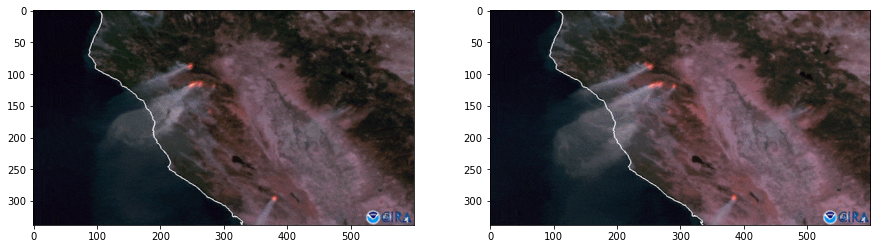

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

def read_jpeg(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.reshape(img, [338, 600, 3])
    return img

ds = tf.data.TextLineDataset('input.txt').map(read_jpeg)
f, ax = plt.subplots(1, 2, figsize=(15,10))
for idx, img in enumerate(ds):
    ax[idx].imshow( img.numpy() );

## Adding a map function

Let's say that we want to apply a custom formula to convert the images.

(338, 600)


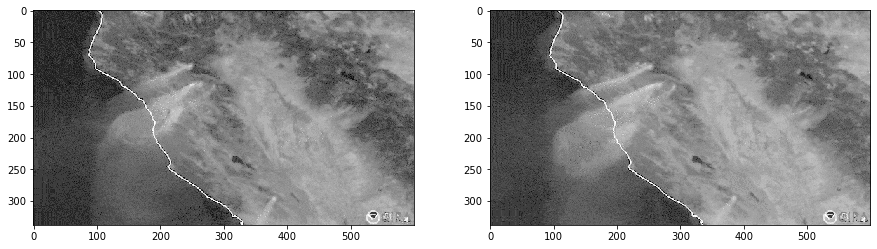

In [5]:
def to_grayscale(img):
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]
    c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    gray = tf.where(c_linear > 0.0031308,
                    1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                    12.92*c_linear)
    print(gray.shape)
    return gray

ds = tf.data.TextLineDataset('input.txt').map(read_jpeg).map(to_grayscale)
f, ax = plt.subplots(1, 2, figsize=(15,10))
for idx, img in enumerate(ds):
    ax[idx].imshow( img.numpy() , cmap='gray', interpolation='none');

### 1. Iterating through image

(don't do this)

In [6]:
# Image in GPU, gray computation in CPU
def to_grayscale(img):
    rows, cols, _ = img.shape
    result = np.zeros([rows, cols])
    for row in range(rows):
        for col in range(cols):
            red = img[row][col][0]
            green = img[row][col][1]
            blue = img[row][col][2]
            c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
            if c_linear > 0.0031308:
                result[row][col] = 1.055 * pow(c_linear, 1/2.4) - 0.055
            else:
                result[row][col] = 12.92*c_linear
    return result

In [7]:
%%timeit
ds = tf.data.TextLineDataset('input.txt').map(read_jpeg)
for img in ds:
    gray = to_grayscale(img.numpy())
    tf.reduce_mean(gray, axis=[0, 1])

4.37 s ± 99.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 2. Use TensorFlow slicing and tf.where

This is 10x faster than iterating.

In [8]:
# All in GPU
def to_grayscale(img):
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]
    c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    gray = tf.where(c_linear > 0.0031308,
                    1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                    12.92*c_linear)
    return gray

In [9]:
%%timeit
ds = tf.data.TextLineDataset('input.txt').map(read_jpeg).map(to_grayscale)
for gray in ds:
    tf.reduce_mean(gray, axis=[0, 1])

438 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 3. Use Matrix math and tf.where

This is 2x as fast as the slicing.

In [10]:
def to_grayscale(img):
    wt = tf.constant([[0.2126], [0.7152], [0.0722]]) # 3x1 matrix
    c_linear = tf.matmul(img, wt) # (ht,wd,3) x (3x1) -> (ht, wd)
    gray = tf.where(c_linear > 0.0031308,
                    1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                    12.92*c_linear)
    return gray

In [11]:
%%timeit
ds = tf.data.TextLineDataset('input.txt').map(read_jpeg).map(to_grayscale)
for gray in ds:
    tf.reduce_mean(gray, axis=[0, 1])

290 ms ± 9.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 4. Pyfunc

If you absolutely need to iterate and still need to use map()

In [12]:
def to_grayscale_numpy(img):
    img = img.numpy()
    rows, cols, _ = img.shape
    result = np.zeros([rows, cols], dtype=np.float32)
    for row in range(rows):
        for col in range(cols):
            red = img[row][col][0]
            green = img[row][col][1]
            blue = img[row][col][2]
            c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
            if c_linear > 0.0031308:
                result[row][col] = 1.055 * pow(c_linear, 1/2.4) - 0.055
            else:
                result[row][col] = 12.92*c_linear
    return tf.convert_to_tensor(result)

def to_grayscale(img):
    return tf.py_function(to_grayscale_numpy, [img], tf.float32)

In [13]:
%%timeit
ds = tf.data.TextLineDataset('input.txt').map(read_jpeg).map(to_grayscale)
for gray in ds:
    tf.reduce_mean(gray, axis=[0, 1])

4.28 s ± 59.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.